# Credit Default Prediction with XGBoost and Hyperparameter Tuning

This notebook covers a full pipeline:
- Load Lending Club dataset from Kaggle
- Data preprocessing
- Model selection: XGBoost for binary classification
- Bayesian Optimization for hyperparameter tuning
- Model evaluation using accuracy, precision, recall, F1-score, AUC-ROC
- Confusion matrix visualization

**Note:** Data is loaded directly from Kaggle using the kaggle API. No local `data/` folder is needed.

In [8]:
# Install required packages (if running in a fresh environment)
!pip install xgboost scikit-learn bayesian-optimization kagglehub matplotlib seaborn --quiet

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
import kagglehub

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Download Lending Club dataset from Kaggle using kagglehub
path = kagglehub.dataset_download("wordsforthewise/lending-club")
print("Dataset files downloaded at:", path)

# Load the credit data CSV (adjust filename if different)
file_path = f"{path}/accepted_2007_to_2018Q4.csv.gz"  # example filename, check actual
df = pd.read_csv(file_path)
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")

Dataset files downloaded at: /Users/poonam/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3


/var/folders/r7/sqqmcy716737551_rvg4fdw80000gn/T/ipykernel_1569/1303959291.py:7: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loaded dataset with 2260701 rows and 151 columns


## Data Overview and Preprocessing
- Check for missing values
- Select relevant features
- Encode categorical variables
- Define target variable (default or not)
- Split data into train/test sets

In [12]:
# Basic EDA
print(df.head())
print(df.isnull().sum())

         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_

In [13]:
# For simplicity, let's select a few numerical and categorical features
features = ["loan_amnt", "int_rate", "installment", "annual_inc", "dti", "open_acc", "revol_bal", "total_acc", "emp_length"]
target = "loan_status"  # Assuming this contains 'Fully Paid' vs 'Charged Off' or similar

# Filter dataset
df = df[features + [target]].dropna()

# Convert target to binary: 1 if default, 0 if fully paid
df["target"] = df[target].apply(lambda x: 1 if x.lower() != "fully paid" else 0)

# Encode employment length categorical feature (example encoding)
def emp_length_to_int(emp):
    if pd.isnull(emp):
        return 0
    if emp == '< 1 year':
        return 0
    if emp == '10+ years':
        return 10
    try:
        return int(emp.split()[0])
    except:
        return 0

df['emp_length'] = df['emp_length'].apply(emp_length_to_int)

# Define X, y
X = df[features].copy()
X['emp_length'] = df['emp_length']
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 1690895, Testing samples: 422724


## Model Selection: XGBoost
XGBoost is chosen for binary classification due to its strong performance on tabular data and multiple tunable hyperparameters.

In [14]:
# Define a function to train and evaluate model given hyperparameters
def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_train)[:,1]
    auc = roc_auc_score(y_train, preds)
    return auc

## Bayesian Optimization for Hyperparameter Tuning
Optimize for highest AUC on training set (with validation later)

In [15]:
from bayes_opt import BayesianOptimization

pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | max_depth | learni... | n_esti... |   gamma   | min_ch... | subsample | colsam... |
-------------------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 1         | 0.7996750 | 5.6217808 | 0.2857071 | 232.99848 | 2.9932924 | 2.4041677 | 0.5779972 | 0.5290418 |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 2         | 0.8193689 | 9.0632330 | 0.1843233 | 227.01814 | 0.1029224 | 9.7291886 | 0.9162213 | 0.6061695 |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 3         | 0.7471480 | 4.2727747 | 0.0631873 | 126.06056 | 2.6237821 | 4.8875051 | 0.6456145 | 0.8059264 |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 4         | 0.7366604 | 3.9764570 | 0.0947219 | 141.59046 | 2.2803499 | 8.0665836 | 0.5998368 | 0.7571172 |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 5         | 0.7670203 | 7.1469019 | 0.0234706 | 201.88621 | 0.8526206 | 1.5854643 | 0.9744427 | 0.9828160 |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 6         | 0.8056658 | 8.8561652 | 0.0967364 | 227.23967 | 0.4151779 | 8.7717027 | 0.8753691 | 0.6636487 |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 7         | 0.8353153 | 10.0      | 0.3       | 224.00803 | 0.0       | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:35:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 8         | 0.8001963 | 5.4345972 | 0.3       | 221.14933 | 0.0       | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 9         | 0.8037509 | 10.0      | 0.3       | 222.79348 | 5.0       | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 10        | 0.7682818 | 10.0      | 0.01      | 216.77189 | 0.0       | 10.0      | 0.5       | 1.0       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 11        | 0.7885744 | 3.8295348 | 0.3       | 240.40484 | 5.0       | 1.0       | 0.6428574 | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 12        | 0.8366652 | 10.0      | 0.3       | 235.25148 | 0.0       | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 13        | 0.8371337 | 10.0      | 0.3       | 239.75329 | 0.0       | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 14        | 0.8034967 | 10.0      | 0.3       | 237.77654 | 5.0       | 10.0      | 0.5       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 15        | 0.8005453 | 5.0591941 | 0.3       | 237.77664 | 0.0       | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 16        | 0.7708296 | 10.0      | 0.01      | 237.95781 | 0.0       | 5.8405293 | 1.0       | 1.0       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 17        | 0.8296942 | 10.0      | 0.3       | 243.02627 | 0.0       | 10.0      | 0.5       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 18        | 0.8016899 | 7.6310114 | 0.3       | 242.80494 | 3.0257075 | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 19        | 0.8127857 | 10.0      | 0.3       | 232.42892 | 2.2589881 | 10.0      | 1.0       | 0.5       |


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:37:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 20        | 0.8301922 | 10.0      | 0.3       | 248.48022 | 0.0       | 10.0      | 0.5       | 0.5       |


## Train Final Model with Best Hyperparameters

In [16]:
# Extract best params
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'binary:logistic'
best_params['use_label_encoder'] = False
best_params['eval_metric'] = 'auc'
best_params['random_state'] = 42

# Train model
final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:38:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.5)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


## Evaluate Model on Test Set with Multiple Metrics

In [17]:
# Predictions
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Accuracy: 0.7196
Precision: 0.7273
Recall: 0.7333
F1 Score: 0.7303
AUC-ROC: 0.7959


## Confusion Matrix Visualization

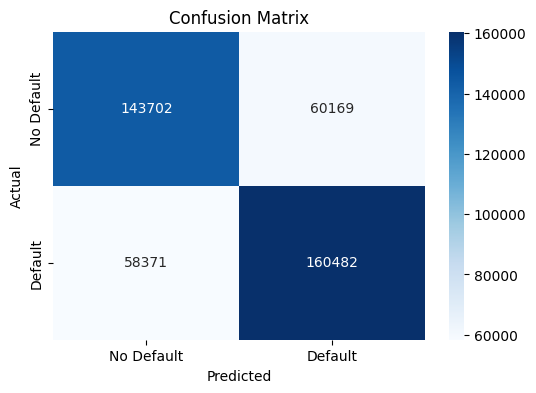

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Summary
- Data loaded directly from Kaggle dataset `wordsforthewise/lending-club`.
- Task: binary classification to predict credit default.
- Model: XGBoost with Bayesian hyperparameter optimization.
- Evaluation using multiple metrics: accuracy, precision, recall, F1, AUC-ROC.
- Confusion matrix plotted for error analysis.

## Next Steps
- Improve feature engineering.
- Use cross-validation for more robust evaluation.
- Experiment with other models and ensembles.
